# Assignment

Lakukan time-series prediction terhadap dataset **Daily Min Temperature** dan **Birth**! Gunakan:
  1. Base model
  2. Deeper model
  3. Wider model
  4. LSTM

Tentukan arsitektur terbaik! Gunakan hyperparameter yang sama dengan yang digunakan secara default seperti contoh diatas untuk perbandingannya.

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

## Datetime parser

In [24]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

In [49]:
dataset = pd.read_csv('/content/drive/My Drive/dataset/birth.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
dataset1 = pd.read_csv('/content/drive/My Drive/dataset/daily-min-temperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

dataset.head()

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64

## Plot dataset

###Birth

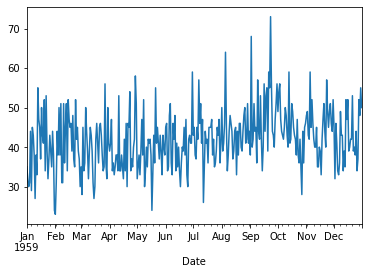

In [26]:
dataset.plot()
plt.show()

###Daily Min Temp

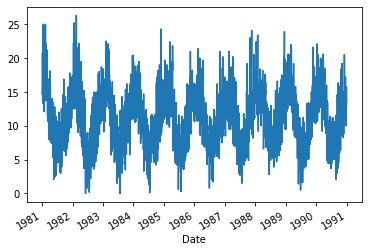

In [50]:
dataset1.plot()
plt.show()

## Processing Time-series Data

###Birth

In [51]:
def timeseries_to_supervised(dta, lag=1):
	df = pd.DataFrame(dta)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

def difference(dts, interval=1):
	diff = list()
	for i in range(interval, len(dts)):
		value = dts[i] - dts[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [29]:
lag = 1

raw_values = dataset.values
diff_values = difference(raw_values, 1)

diff_values

0      -3
1      -2
2       1
3      13
4     -15
       ..
359     3
360    15
361    -4
362     7
363    -5
Length: 364, dtype: int64

In [30]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0
0,NaN,-3
1,-3.0,-2
2,-2.0,1
3,1.0,13
4,13.0,-15
...,...,...
359,-10.0,3
360,3.0,15
361,15.0,-4
362,-4.0,7


In [31]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[ -3.,  -2.],
       [ -2.,   1.],
       [  1.,  13.],
       [ 13., -15.],
       [-15.,  16.],
       [ 16.,  -2.],
       [ -2.,  -5.],
       [ -5., -11.],
       [-11.,  11.],
       [ 11.,  -5.],
       [ -5.,  22.],
       [ 22.,  -8.],
       [ -8.,  -2.],
       [ -2.,  -8.],
       [ -8.,  13.],
       [ 13.,  -7.],
       [ -7.,  -2.],
       [ -2.,  11.],
       [ 11., -18.],
       [-18.,  19.],
       [ 19., -14.],
       [-14.,  -7.],
       [ -7.,   5.],
       [  5.,   6.],
       [  6.,  -4.],
       [ -4.,  -4.],
       [ -4.,   9.],
       [  9.,  -6.],
       [ -6., -14.],
       [-14.,  -1.],
       [ -1.,   8.],
       [  8.,  13.],
       [ 13.,  -6.],
       [ -6.,  12.],
       [ 12., -12.],
       [-12.,  13.],
       [ 13., -20.],
       [-20.,   0.],
       [  0.,  20.],
       [ 20., -15.],
       [-15.,   9.],
       [  9.,   6.],
       [  6., -17.],
       [-17.,  18.],
       [ 18.,  -5.],
       [ -5.,  -2.],
       [ -2.,   1.],
       [  1.,

In [32]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [33]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) # Range hasil scaling menjadi angka diantara -1 hingga 1
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [34]:
train_scaled

array([[-1.37931034e-01, -1.03448276e-01],
       [-1.03448276e-01, -6.93889390e-17],
       [-6.93889390e-17,  4.13793103e-01],
       [ 4.13793103e-01, -5.51724138e-01],
       [-5.51724138e-01,  5.17241379e-01],
       [ 5.17241379e-01, -1.03448276e-01],
       [-1.03448276e-01, -2.06896552e-01],
       [-2.06896552e-01, -4.13793103e-01],
       [-4.13793103e-01,  3.44827586e-01],
       [ 3.44827586e-01, -2.06896552e-01],
       [-2.06896552e-01,  7.24137931e-01],
       [ 7.24137931e-01, -3.10344828e-01],
       [-3.10344828e-01, -1.03448276e-01],
       [-1.03448276e-01, -3.10344828e-01],
       [-3.10344828e-01,  4.13793103e-01],
       [ 4.13793103e-01, -2.75862069e-01],
       [-2.75862069e-01, -1.03448276e-01],
       [-1.03448276e-01,  3.44827586e-01],
       [ 3.44827586e-01, -6.55172414e-01],
       [-6.55172414e-01,  6.20689655e-01],
       [ 6.20689655e-01, -5.17241379e-01],
       [-5.17241379e-01, -2.75862069e-01],
       [-2.75862069e-01,  1.37931034e-01],
       [ 1.

###Daily Min Temp

In [52]:
raw_values1 = dataset1.values
diff_values1 = difference(raw_values1, 1)

diff_values1

0      -2.8
1       0.9
2      -4.2
3       1.2
4       0.0
       ... 
3644   -0.6
3645   -0.4
3646   -0.1
3647    2.2
3648   -2.7
Length: 3649, dtype: float64

In [53]:
supervised1 = timeseries_to_supervised(diff_values1, lag)
supervised1

,0,0
0,NaN,-2.8
1,-2.8,0.9
2,0.9,-4.2
3,-4.2,1.2
4,1.2,0.0
...,...,...
3644,1.7,-0.6
3645,-0.6,-0.4
3646,-0.4,-0.1
3647,-0.1,2.2


In [54]:
supervised_values1 = supervised1.values[lag:,:]
supervised_values1

array([[-2.8,  0.9],
       [ 0.9, -4.2],
       [-4.2,  1.2],
       ...,
       [-0.4, -0.1],
       [-0.1,  2.2],
       [ 2.2, -2.7]])

In [55]:
split_percentage = 0.75

train_size1 = int(split_percentage * len(supervised_values1))

train1, test1 = supervised_values1[0:train_size1], supervised_values1[train_size1:len(supervised_values1)]


In [56]:
scaler1 = MinMaxScaler(feature_range=(-1, 1)) # Range hasil scaling menjadi angka diantara -1 hingga 1
scaler1 = scaler1.fit(train1)

train_scaled1 = scaler1.transform(train1)
test_scaled1 = scaler1.transform(test1)

In [57]:
train_scaled1

array([[-0.11607143,  0.21428571],
       [ 0.21428571, -0.24107143],
       [-0.24107143,  0.24107143],
       ...,
       [-0.16071429,  0.375     ],
       [ 0.375     ,  0.125     ],
       [ 0.125     , -0.16071429]])

## Baseline model

###Birth

In [35]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.1135 - val_loss: 0.0709
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1130 - val_loss: 0.0706
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1125 - val_loss: 0.0703
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1120 - val_loss: 0.0701
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1117 - val_loss: 0.0699
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1114 - val_loss: 0.0697
Epoch 7/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1112 - val_loss: 0.0697
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1111 - val_loss: 0.0696
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1110 - val_loss: 0.0695
Epoch 10/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1110 - val_loss: 0.0695
Epoch 11/1000
9/9 

In [36]:
loss = model.evaluate(feature_test, label_test, verbose=2)

print("Test loss:", loss)

3/3 - 0s - loss: 0.0694
Test loss: 0.06939689069986343


In [37]:
def plot_loss(hstr):
  plt.plot(hstr.history['loss'], label='loss')
  plt.plot(hstr.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)

In [38]:
history_dataframe = pd.DataFrame(history.history)
history_dataframe['epoch'] = history.epoch
history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
390,0.110785,0.069397,390
225,0.110762,0.069397,225
269,0.110802,0.069397,269
591,0.110791,0.069397,591
133,0.110763,0.069397,133
...,...,...,...
4,0.111681,0.069867,4
3,0.111996,0.070055,3
2,0.112458,0.070263,2
1,0.112960,0.070577,1


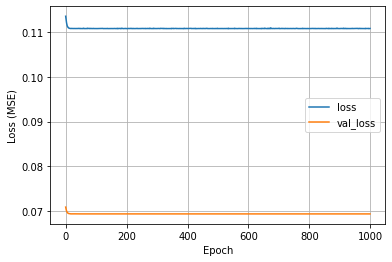

In [39]:
plot_loss(history) # epoch vs loss graph

###Daily Min Temp

In [58]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train1, label_train1 = train_scaled1[:, 0:-1], train_scaled1[:, -1]
feature_test1, label_test1 = test_scaled1[:, 0:-1], test_scaled1[:, -1]

model1 = Sequential()
model1.add(Dense(neurons, activation='relu', input_dim=feature_train1.shape[1]))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')
history1 = model1.fit(feature_train1, label_train1, epochs=epoch, batch_size=batch_size, validation_data=(feature_test1, label_test1))


Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0854 - val_loss: 0.0665
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0587
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0570
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0565
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.0563
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0562
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0562
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0562
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0561
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0561

In [59]:
loss1 = model1.evaluate(feature_test1, label_test1, verbose=2)

print("Test loss:", loss1)

29/29 - 0s - loss: 0.0559
Test loss: 0.05593771114945412


In [60]:
history_dataframe1 = pd.DataFrame(history1.history)
history_dataframe1['epoch'] = history1.epoch
history_dataframe1.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
476,0.060669,0.055938,476
976,0.060660,0.055938,976
589,0.060666,0.055938,589
547,0.060656,0.055938,547
423,0.060657,0.055938,423
...,...,...,...
4,0.061195,0.056345,4
3,0.061493,0.056539,3
2,0.062495,0.056993,2
1,0.066915,0.058688,1


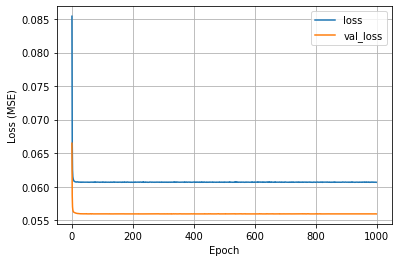

In [61]:
plot_loss(history1) # epoch vs loss graph

## Deeper model

###Birth

In [40]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.1395 - val_loss: 0.0815
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1336 - val_loss: 0.0790
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1293 - val_loss: 0.0771
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1264 - val_loss: 0.0757
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1234 - val_loss: 0.0744
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1212 - val_loss: 0.0734
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1194 - val_loss: 0.0727
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1176 - val_loss: 0.0722
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1162 - val_loss: 0.0717
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1150 - val_loss: 0.0713
Epoch 11/1000
9/9 

In [41]:
deeper_history_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_history_dataframe['epoch'] = deeper_model_history.epoch
deeper_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
877,0.081310,0.053873,877
540,0.081296,0.053929,540
366,0.081705,0.053930,366
458,0.081684,0.053941,458
401,0.081541,0.053947,401
...,...,...,...
4,0.123441,0.074446,4
3,0.126428,0.075670,3
2,0.129336,0.077072,2
1,0.133577,0.078957,1


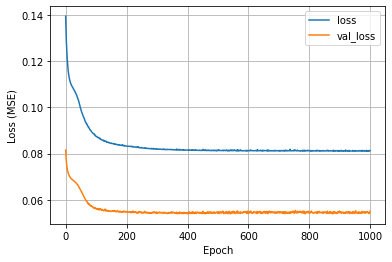

In [42]:
plot_loss(deeper_model_history) # epoch vs loss graph


###Daily Min Temp

In [62]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model1 = Sequential()
deeper_model1.add(Dense(neurons, activation='relu', input_dim=feature_train1.shape[1]))
deeper_model1.add(Dense(5, activation='relu'))
deeper_model1.add(Dense(1))
deeper_model1.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history1 = deeper_model1.fit(feature_train1, label_train1, epochs=epoch, batch_size=batch_size, validation_data=(feature_test1, label_test1))


Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0578
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0561
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0552
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0595 - val_loss: 0.0546
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.0542
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0541
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0540
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0585 - val_loss: 0.0540
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0539
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0539

In [63]:
deeper_history_dataframe1 = pd.DataFrame(deeper_model_history1.history)
deeper_history_dataframe1['epoch'] = deeper_model_history1.epoch
deeper_history_dataframe1.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
221,0.058415,0.053934,221
492,0.058390,0.053935,492
56,0.058420,0.053935,56
293,0.058394,0.053935,293
336,0.058392,0.053936,336
...,...,...,...
35,0.058254,0.054340,35
3,0.059524,0.054620,3
2,0.060408,0.055193,2
1,0.061676,0.056149,1


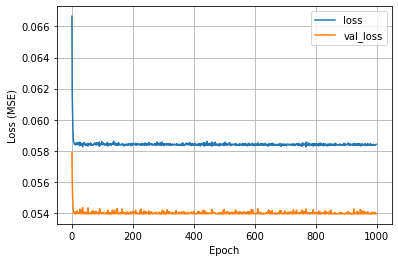

In [64]:
plot_loss(deeper_model_history1)

## Wider model

###Birth

In [43]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.1002 - val_loss: 0.0604
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0920 - val_loss: 0.0574
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0877 - val_loss: 0.0565
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0856 - val_loss: 0.0563
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0848 - val_loss: 0.0559
Epoch 6/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0841 - val_loss: 0.0558
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0832 - val_loss: 0.0553
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0829 - val_loss: 0.0546
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0824 - val_loss: 0.0544
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0821 - val_loss: 0.0542
Epoch 11/1000
9/9 

In [44]:
wider_history_dataframe = pd.DataFrame(wider_model_history.history)
wider_history_dataframe['epoch'] = wider_model_history.epoch
wider_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
15,0.081222,0.054046,15
160,0.080679,0.054131,160
86,0.081092,0.054138,86
19,0.080957,0.054141,19
123,0.080496,0.054161,123
...,...,...,...
4,0.084792,0.055889,4
3,0.085592,0.056321,3
2,0.087670,0.056492,2
1,0.091960,0.057448,1


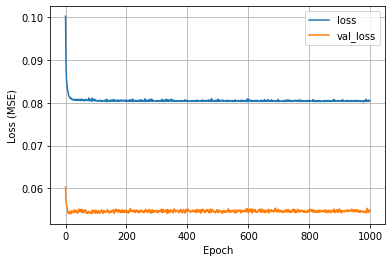

In [45]:
plot_loss(wider_model_history) # epoch vs loss graph

###Daily Min Temp

In [65]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model1 = Sequential()
wider_model1.add(Dense(neurons, activation='relu', input_dim=feature_train1.shape[1]))
wider_model1.add(Dense(1))
wider_model1.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history1 = wider_model1.fit(feature_train1, label_train1, epochs=epoch, batch_size=batch_size, validation_data=(feature_test1, label_test1))


Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0629 - val_loss: 0.0545
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0540
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0585 - val_loss: 0.0542
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0542
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0539
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0583 - val_loss: 0.0538
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0581 - val_loss: 0.0541
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0539
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0581 - val_loss: 0.0538
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0581 - val_loss: 0.0538

In [66]:
wider_history_dataframe1 = pd.DataFrame(wider_model_history1.history)
wider_history_dataframe1['epoch'] = wider_model_history1.epoch
wider_history_dataframe1.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
11,0.057985,0.053694,11
19,0.057968,0.053740,19
50,0.057940,0.053761,50
25,0.057968,0.053764,25
31,0.057978,0.053764,31
...,...,...,...
939,0.057409,0.054489,939
959,0.057407,0.054534,959
841,0.057446,0.054544,841
38,0.057967,0.054546,38


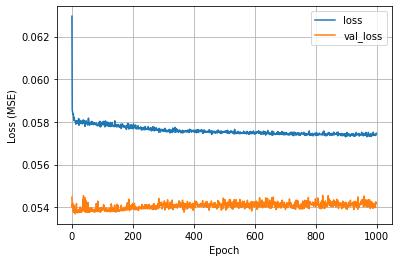

In [67]:
plot_loss(wider_model_history1) # epoch vs loss graph

## LSTM

###Birth

In [46]:
from tensorflow.keras.layers import LSTM

epoch = 1000
batch_size = 32

# Reshape menjadi (jumlah sample, time steps, jumlah feature)
# Time steps: jumlah lag, gunakan default 1
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 23ms/step - loss: 0.1139 - val_loss: 0.0699
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1106 - val_loss: 0.0680
Epoch 3/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1079 - val_loss: 0.0666
Epoch 4/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1056 - val_loss: 0.0655
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1037 - val_loss: 0.0645
Epoch 6/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1020 - val_loss: 0.0636
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1003 - val_loss: 0.0628
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0988 - val_loss: 0.0620
Epoch 9/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0973 - val_loss: 0.0611
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0957 - val_loss: 0.0604
Epoch 11/1000
9/9 

In [47]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
92,0.080601,0.054237,92
53,0.080535,0.054312,53
55,0.080484,0.054332,55
71,0.080762,0.054345,71
122,0.080433,0.054379,122
...,...,...,...
4,0.103684,0.064538,4
3,0.105649,0.065513,3
2,0.107898,0.066604,2
1,0.110564,0.068006,1


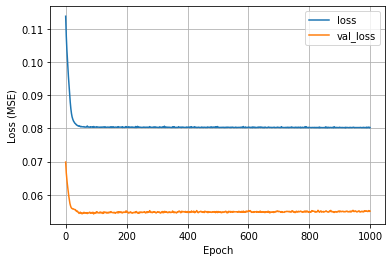

In [48]:
plot_loss(lstm_model_history)

###Daily Min Temp

In [68]:
epoch = 1000
batch_size = 32

# Reshape menjadi (jumlah sample, time steps, jumlah feature)
# Time steps: jumlah lag, gunakan default 1

feature_train_reshaped1 = np.reshape(feature_train1, (feature_train1.shape[0], 1, feature_train1.shape[1]))
feature_test_reshaped1 = np.reshape(feature_test1, (feature_test1.shape[0], 1, feature_test1.shape[1]))

lstm_model1 = Sequential()
lstm_model1.add(LSTM(50, activation='relu', input_dim=feature_train1.shape[1])) # 50 LSTM Block
lstm_model1.add(Dense(1))
lstm_model1.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history1 = lstm_model1.fit(feature_train_reshaped1, label_train1, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped1, label_test1))


Epoch 1/1000
86/86 [==============================] - 0s 4ms/step - loss: 0.0656 - val_loss: 0.0554
Epoch 2/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0593 - val_loss: 0.0542
Epoch 3/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0540
Epoch 4/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0539
Epoch 5/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0540
Epoch 6/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0541
Epoch 7/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0540
Epoch 8/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0539
Epoch 9/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0539
Epoch 10/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0539

In [69]:
lstm_history_dataframe1 = pd.DataFrame(lstm_model_history1.history)
lstm_history_dataframe1['epoch'] = lstm_model_history1.epoch
lstm_history_dataframe1.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
393,0.057790,0.053767,393
373,0.057997,0.053768,373
388,0.057840,0.053777,388
429,0.057788,0.053779,429
439,0.057815,0.053781,439
...,...,...,...
317,0.058057,0.054358,317
51,0.058243,0.054465,51
67,0.058185,0.054488,67
50,0.058202,0.054758,50


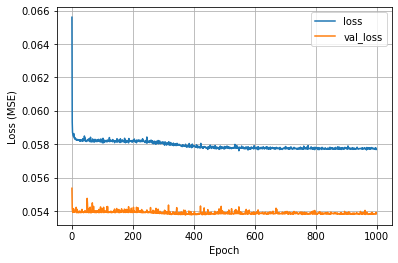

In [70]:
plot_loss(lstm_model_history1)

#Kesimpulan:
##### Untuk dataset birth, nilai terbaik yang didapat adalah pada model deeper dengan loss=0.08, dan v_los=0.05
##### Untuk dataset daily temperature nilai terbaik yang didapat adalah pada model wider dengan loss=0.057 dan v_loss=0.053